In [896]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import re

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Business Understanding

Here we use the Seattle and Boston AirBnB data to answer the following questions:

1. What are the most and least expensive times to rent in each city?
2. What are the most important features which drive the rental prices?  Are these different between the Seattle and Boston data?
3. Are there any strategies a potential renter may take to get a cheaper price on good properties?
4. Are the peak times of year in Seattle and Boston the same?


# Data Understanding

Here we get an overall understanding of the datasets, including:

1. Basic statistics
2. Number of missing values for each attribute
3. Distribution of key fields
4. Visual exploration of relationships between key attributes


### Data Import and Initial Cleanup

In [851]:
# Import the Boston data
bos_list = pd.read_csv('./Data/Boston/listings.csv')
bos_cal  = pd.read_csv('./Data/Boston/calendar.csv')
# bos_rev  = pd.read_csv('./Data/Boston/reviews.csv')

# Import the Seattle data
sea_list = pd.read_csv('./Data/Seattle/listings.csv')
sea_cal  = pd.read_csv('./Data/Seattle/calendar.csv')
# sea_rev  = pd.read_csv('./Data/Seattle/reviews.csv')

# Rename the 'id' field in the listing data to 'listing_id' to match the other tables
bos_list.rename(columns={'id':'listing_id'}, inplace=True)
sea_list.rename(columns={'id':'listing_id'}, inplace=True)

# Set indicies to the 'listing_id' on all dataframes
bos_list.set_index('listing_id', inplace=True)
bos_cal.set_index('listing_id', inplace=True)
# bos_rev.set_index('listing_id', inplace=True)

sea_list.set_index('listing_id', inplace=True)
sea_cal.set_index('listing_id', inplace=True)
# sea_rev.set_index('listing_id', inplace=True)

sea_cal.head()

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
224763,2021-03-19,t,$159.00,$159.00,2.0,365.0
226536,2021-03-20,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-21,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-22,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-23,f,$41.00,$41.00,1.0,1125.0


In [852]:
# Check to see if the Seattle and Boston listing datasets have the same columns
seattle_not_boston = list(set(sea_list.columns) - set(bos_list.columns))
boston_not_seattle = list(set(bos_list.columns) - set(sea_list.columns))

print("Columns in Seattle set but not in Boston set: ", seattle_not_boston)
print("Columns in Boston set but not in Seattle set: ", boston_not_seattle)

Columns in Seattle set but not in Boston set:  []
Columns in Boston set but not in Seattle set:  []


In [853]:
sea_list.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',

In [854]:
# Drop columns not relevant to this analysis
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 
       'description', 'neighborhood_overview', 
       'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 
       'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_updated', 'calendar_last_scraped',
       'first_review', 'last_review', 
       'license', 'instant_bookable',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count']

sea_list.drop(columns=cols_to_drop + seattle_not_boston, inplace=True)
bos_list.drop(columns=cols_to_drop + boston_not_seattle, inplace=True)

# Combine Boston and Seattle data into common dataframes
sea_list['city'] = 'Seattle'
bos_list['city'] = 'Boston'
df_list = pd.concat([sea_list, bos_list], axis=0)

sea_cal['city'] = 'Seattle'
bos_cal['city'] = 'Boston'
df_cal = pd.concat([sea_cal, bos_cal], axis=0)

# Add the 'neighbourhood_cleansed' column to the calendar dataset
df_cal = df_cal.join(df_list[['neighbourhood_cleansed']])

df_list.head()

,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,...,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
listing_id,,,,,,,,,,,,,,,,,,,,,
2318,f,Madrona,Entire house,Entire home/apt,9,NaN,2.5 baths,4.0,4.0,"[""Heating"", ""Kitchen"", ""Host greets you"", ""Ind...",...,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.21,Seattle
9419,t,Georgetown,Private room in apartment,Private room,2,NaN,3 shared baths,1.0,2.0,"[""Smoke alarm"", ""Patio or balcony"", ""Shampoo"",...",...,0,93.0,10.0,10.0,10.0,10.0,10.0,10.0,1.14,Seattle
9531,t,Fairmount Park,Entire house,Entire home/apt,4,NaN,1 bath,2.0,3.0,"[""TV"", ""Smoke alarm"", ""Patio or balcony"", ""Bar...",...,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.37,Seattle
9534,t,Fairmount Park,Entire guest suite,Entire home/apt,3,NaN,1 bath,2.0,2.0,"[""TV"", ""Smoke alarm"", ""Patio or balcony"", ""Bar...",...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.50,Seattle
9596,f,Wallingford,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,4.0,"[""TV"", ""Smoke alarm"", ""Smart lock"", ""Patio or ...",...,0,91.0,9.0,9.0,10.0,9.0,10.0,9.0,0.82,Seattle


In [855]:
# Check for missing values in listing data
missing_vals = df_list.isnull().sum().sort_values(ascending = False)
missing_vals[missing_vals > 0]

bathrooms                      7147
review_scores_checkin          1613
review_scores_value            1612
review_scores_location         1612
review_scores_accuracy         1612
review_scores_cleanliness      1611
review_scores_communication    1610
review_scores_rating           1568
reviews_per_month              1546
bedrooms                        939
host_is_superhost               256
beds                             77
bathrooms_text                   10
dtype: int64

In [856]:
# Convert boolean string fields to 0-1 indicator
df_list.replace({'host_is_superhost': {'t': 1, 'f': 0}}, inplace=True)
df_cal.replace({'available': {'t': 1, 'f': 0}}, inplace=True)

In [857]:
# Convert date fields to DateTime64
df_cal.date = pd.to_datetime(df_cal.date)

In [858]:
# Convert price fields to float
df_cal.price = df_cal.price.str.replace('[^\d\.]','', regex=True).astype('float')
df_list.price = df_list.price.str.replace('[^\d\.]','', regex=True).astype('float')

### Exploratory Data Analysis

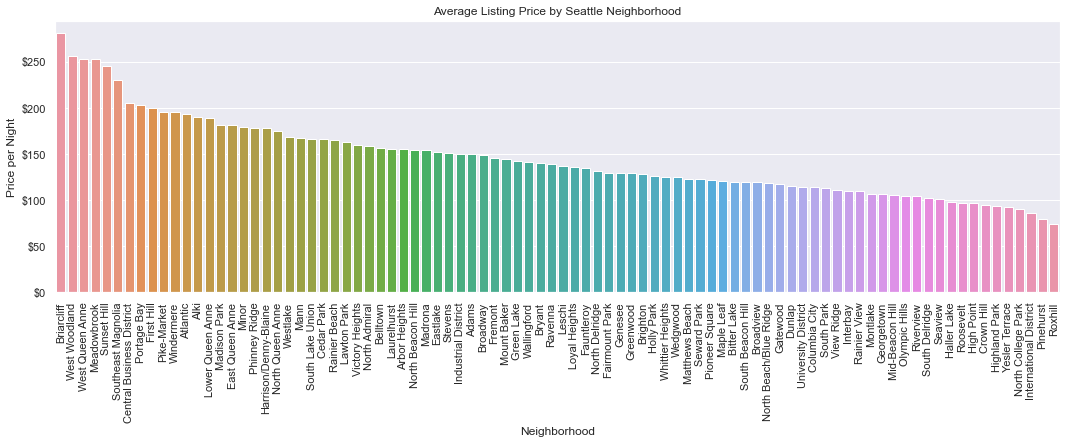

In [859]:
# Plot mean price by neighborhood for Seattle
fig, ax = plt.subplots(1, 1, figsize=(18,5))

tmp = df_cal[df_cal.city == 'Seattle'].reset_index() \
       .groupby(['neighbourhood_cleansed']) \
       .price.mean() \
       .sort_values(ascending=False) \
       .to_frame(name='price') \
       .reset_index()

_ = sns.barplot(x='neighbourhood_cleansed', y='price', data=tmp, ax=ax)
_ = plt.title("Average Listing Price by Seattle Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")
_ = plt.xticks(rotation='vertical')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

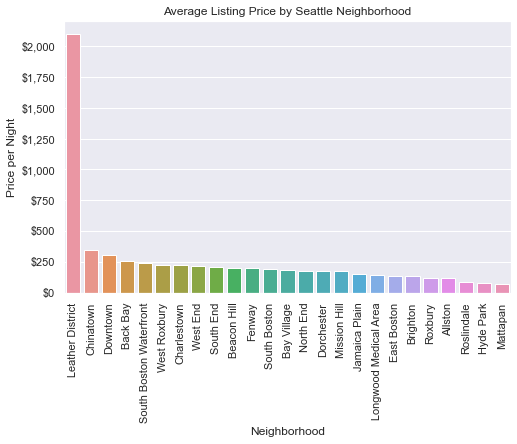

In [860]:
# Plot mean price by neighborhood for Boston
fig, ax = plt.subplots(1, 1, figsize=(8,5))

tmp = df_cal[df_cal.city == 'Boston'].reset_index() \
       .groupby(['neighbourhood_cleansed']) \
       .price.mean() \
       .sort_values(ascending=False) \
       .to_frame(name='price') \
       .reset_index()

_ = sns.barplot(x='neighbourhood_cleansed', y='price', data=tmp, ax=ax)
_ = plt.title("Average Listing Price by Seattle Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")
_ = plt.xticks(rotation='vertical')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

In [861]:
print('Seattle date range: ', 
      df_cal[df_cal.city == 'Seattle'].date.min().strftime('%Y-%m-%d'), 
      ' to ', 
      df_cal[df_cal.city == 'Seattle'].date.max().strftime('%Y-%m-%d'))

print('Boston date range: ', 
      df_cal[df_cal.city == 'Boston'].date.min().strftime('%Y-%m-%d'), 
      ' to ', 
      df_cal[df_cal.city == 'Boston'].date.max().strftime('%Y-%m-%d'))


Seattle date range:  2021-03-18  to  2022-04-05
Boston date range:  2021-03-12  to  2022-03-31


In [862]:
# Make sure date ranges line up between Boston and Seattle
df_cal = df_cal[(df_cal.date > '2021-03-18') & (df_cal.date < '2022-03-15')]

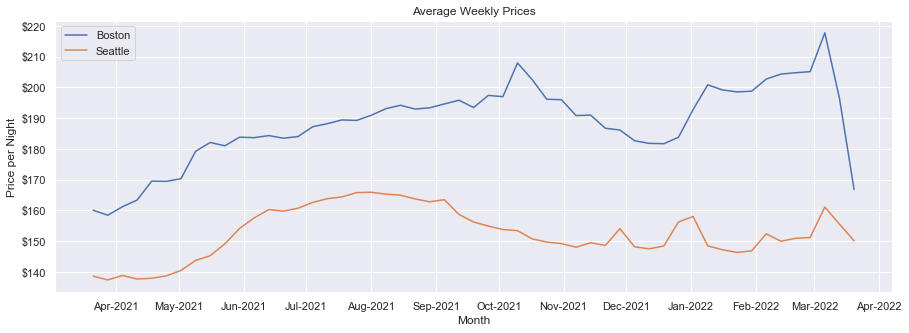

In [863]:
# Plot average weekly prices for both cities
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# Group by city and resample to weekly to calculate the average prices
tmp = df_cal \
       .reset_index() \
       .groupby('city') \
       .resample('W', on='date') \
       .price \
       .mean() \
       .to_frame(name='price') \
       .reset_index()

# Create the plot
sns.lineplot(data=tmp, x='date', y='price', hue='city', ax=ax)

# Create title and legend
_ = plt.title('Average Weekly Prices')
_ = plt.legend()
_ = plt.xlabel("Month")
_ = plt.ylabel("Price per Night")

# Format the prices on the y-axis to currency format
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

# Format the x-axis to show monthly dates
date_form = mdates.DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.show()

Looks like the Boston Marathon spikes prices!  For Seattle, summer is higher as well as Thanksgiving and Christmas.

In [864]:
# Consolidate the 'property_type' field to just a few main choices
def condense_proptype(prop_type):
    if prop_type in ['Entire house', 'Entire cottage',
       'Entire guesthouse', 
       'Entire bungalow', 'Entire place', 'Tiny house',
       'Entire cabin', 
       'Entire villa', 'Entire home/apt',
       'Entire bed and breakfast']:
        return 'House'
    elif prop_type in ['Entire townhouse']:
        return 'Townhouse'
    elif prop_type in ['Entire apartment', 'Entire serviced apartment']:
        return 'Apartment' 
    elif prop_type in ['Private room in apartment', 'Entire guest suite',
       'Private room in house', 
       'Private room in cottage', 'Private room in guest suite',
       'Private room in bungalow', 'Private room in townhouse', 
       'Private room in bed and breakfast',
       'Private room in condominium', 
       'Private room in serviced apartment', 
       'Private room in treehouse', 
       'Room in bed and breakfast', 'Private room in hostel', 'Room in boutique hotel',
       'Private room in villa', 'Private room', 'Private room in loft',
       'Private room in guesthouse',
       'Private room in earth house', 'Room in hotel',
       'Private room in tiny house', 'Room in serviced apartment',
       'Room in aparthotel',
       'Room in hostel']:
        return 'Private Room' 
    elif prop_type in ['Shared room in house', 'Shared room in townhouse',
       'Shared room', 'Shared room in apartment',
       'Shared room in loft', 
       'Shared room in hostel', 
       'Shared room in bed and breakfast', 'Shared room in condominium',
       'Shared room in boutique hotel']:
        return 'Shared Room' 
    elif prop_type in ['Entire condominium']:
        return 'Condominium' 
    else:
        return 'Other'
        
df_list['property_type'] = df_list['property_type'].apply(condense_proptype)
df_list.property_type.value_counts()

Apartment       2750
Private Room    2352
House           1126
Condominium      564
Townhouse        219
Other             81
Shared Room       55
Name: property_type, dtype: int64

In [865]:
# Create a field for the month
df_cal['month'] = df_cal.date.dt.month

In [866]:
# Add a flag indicating shared bathrooms
df_list['shared_bathroom'] = df_list.bathrooms_text.str.contains('shared', case=False).fillna(0).astype('int')

# Replace 'half-bath' with '0.5'
mask = df_list.bathrooms_text.str.contains('half-bath', case=False, na=False)
df_list.loc[mask, 'bathrooms_text'] = '0.5'

# Strip all non-digit characters from 'bathrooms_text', convert to float, and assign to 'bathrooms'
df_list.bathrooms = df_list.bathrooms_text.str.replace('[^\d\.]','', regex=True).astype('float')

# Drop the bathroom text field
df_list.drop(columns='bathrooms_text', inplace=True)

df_list.bathrooms.value_counts()

1.0     5326
2.0      939
1.5      376
2.5      218
3.0      140
3.5       80
0.0       19
0.5       11
4.0       11
6.0        5
4.5        5
5.0        4
16.0       3
Name: bathrooms, dtype: int64

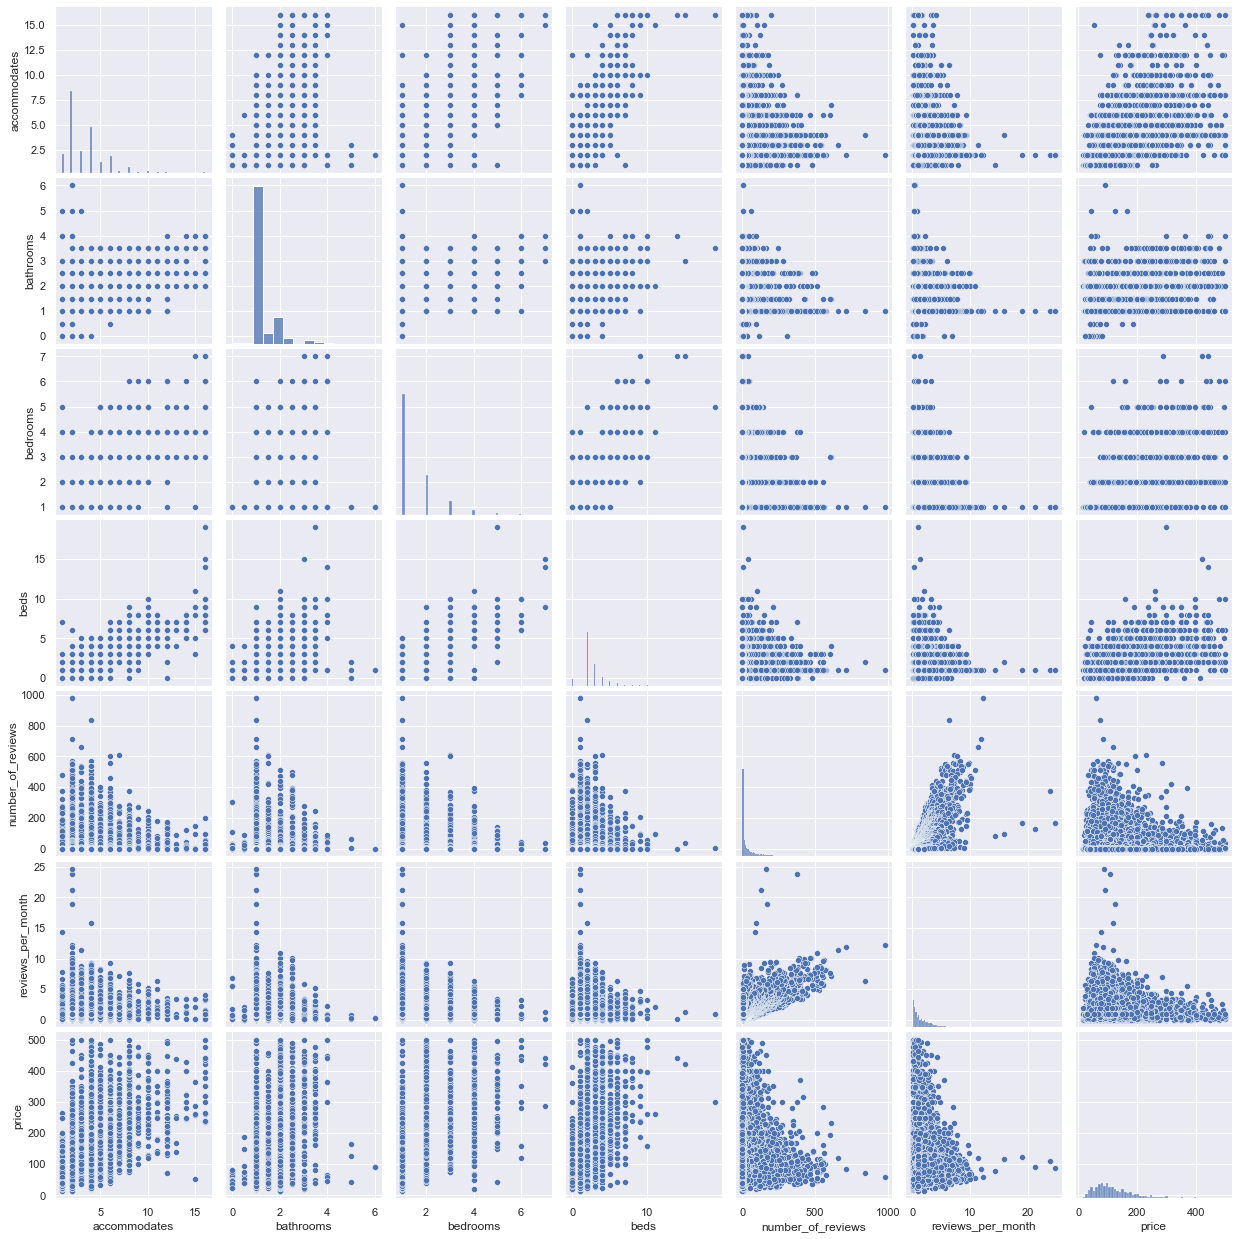

In [867]:
# Pairplot for numeric features
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
       'number_of_reviews', 'reviews_per_month', 'price']

mask = (df_list.price < 500) & (df_list.bathrooms < 10) & (df_list.minimum_nights <100)

_ = sns.pairplot(df_list.loc[mask, cols])

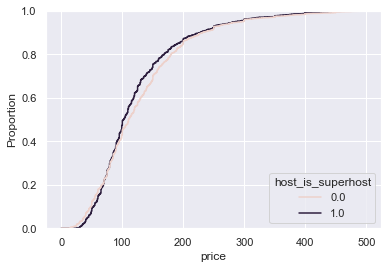

In [868]:
mask = (df_list.price < 500) 
_ = sns.ecdfplot(data=df_list.loc[mask,:], x='price', hue='host_is_superhost')

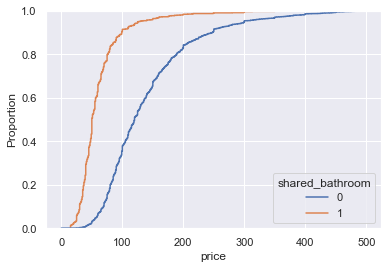

In [869]:
mask = (df_list.price < 500) 
_ = sns.ecdfplot(data=df_list.loc[mask,:], x='price', hue='shared_bathroom')

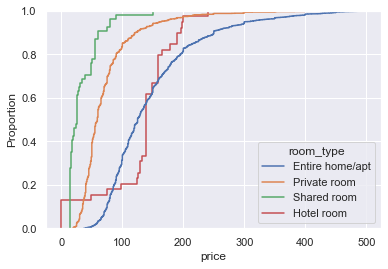

In [870]:
mask = (df_list.price < 500) 
_ = sns.ecdfplot(data=df_list.loc[mask,:], x='price', hue='room_type')

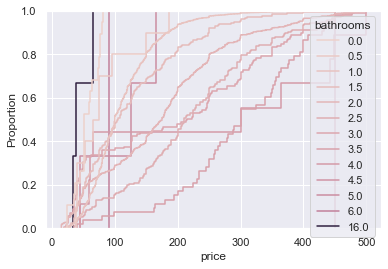

In [871]:
mask = (df_list.price < 500) 
_ = sns.ecdfplot(data=df_list.loc[mask,:], x='price', hue='bathrooms')

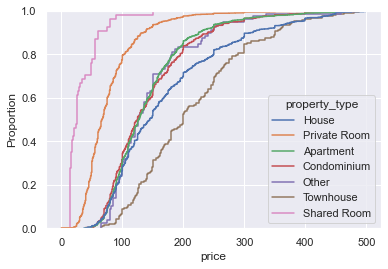

In [872]:
mask = (df_list.price < 500) 
_ = sns.ecdfplot(data=df_list.loc[mask,:], x='price', hue='property_type')

### Fill Missing Values

In [873]:
# Fill missing continuous value columns with mean value
numeric_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                'review_scores_value', 'reviews_per_month']

for col in numeric_cols:
    df_list[col].fillna(df_list[col].mean(), inplace=True)
    
# Fill missing categorical value columns with mode
cat_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
           'room_type']

for col in cat_cols:
    df_list[col].fillna(df_list[col].mode()[0], inplace=True)

# Fill the rest of missing values with zero
fill_zero = ['host_is_superhost', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
             'shared_bathroom']

for col in fill_zero:
    df_list[col].fillna(0, inplace=True)

# Check there are no more missing values
df_list.isnull().sum()

host_is_superhost              0
neighbourhood_cleansed         0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
city                           0
shared_bathroom                0
dtype: int64

### Check Correlations

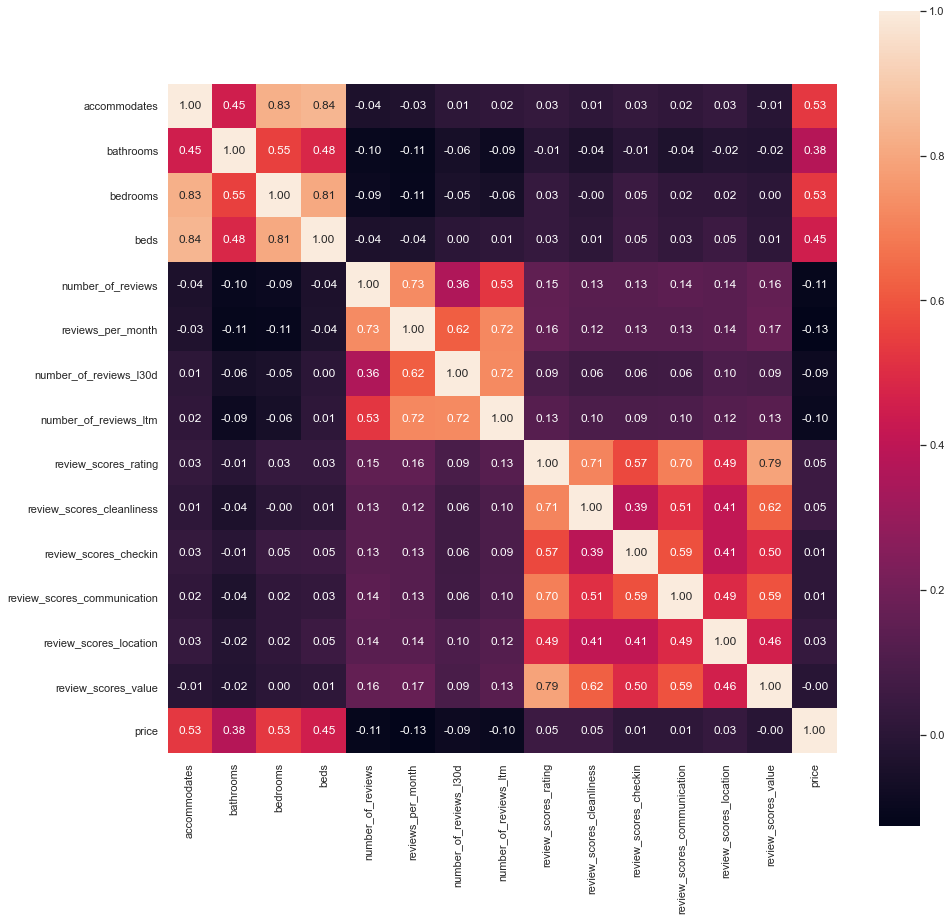

In [874]:
# Check correlations of numerical columns for Seattle

cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
        'number_of_reviews', 'reviews_per_month', 
        'number_of_reviews_l30d', 'number_of_reviews_ltm',
        'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value',
        'price']

mask = df_list.city == 'Seattle'

#Find out correlation between columns and plot
corrs = np.corrcoef(df_list.loc[mask, cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(15,15)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols)

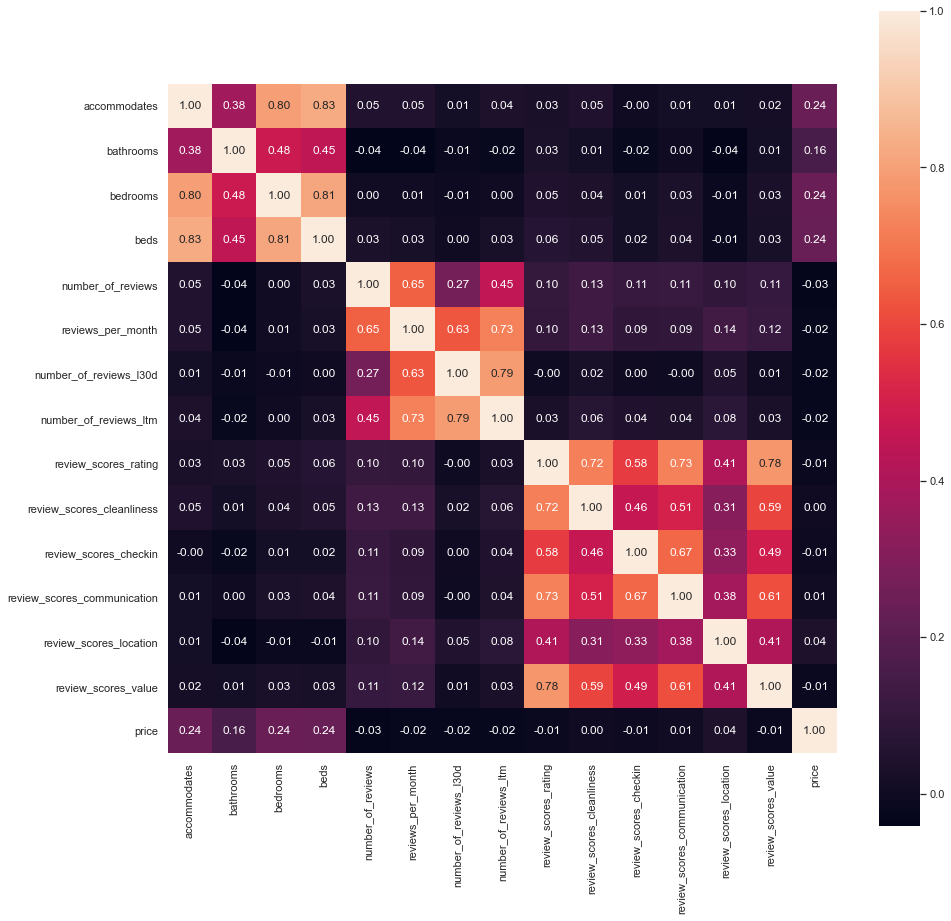

In [875]:
# Check correlations of numerical columns for Boston

cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
        'number_of_reviews', 'reviews_per_month', 
        'number_of_reviews_l30d', 'number_of_reviews_ltm',
        'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value',
        'price']

mask = df_list.city == 'Boston'

#Find out correlation between columns and plot
corrs = np.corrcoef(df_list.loc[mask, cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(15,15)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols)

### Create Dummy Variables for Categorical Columns

In [876]:
### Deal with 'amenities' field

def check_for_substrings(val_list, sublist):
    '''
    Function to check if a list of strings contains any of a list of substrings
    
    Inputs:
        val_list = String-valued list of input strings
        sublist  = List of substrings to check
        
    Output:
        True if any of the substrings are contained in val_list, False otherwise
    '''
    
    cnt = 0
    for val in val_list.replace('[', '').replace("'", '') \
                       .replace("]", '').replace('"', '') \
                       .replace('{', '').replace('}', '').split(','):
        if any(map(val.lower().__contains__, sublist)):
            cnt += 1
            
    if cnt > 0:
        return 1
    else:
        return 0


# Get unique set of amenities
value_list = []
for list_val in df_list.amenities.unique():
    for value in list_val.replace('[', '').replace("'", '') \
                         .replace("]", '').replace('"', '') \
                         .replace('{', '').replace('}', '').split(','):
        value_list.append(value.strip())

value_list = list(set(value_list))
# print(value_list)

# Create lists of similiar amenities for grouping
tv_list = ['tv', 'hdtv', 'cable', 'netflix', 'hbo', 'amazon', 
           'bluetooth', 'nintendo', 'game', 'apple', 'toys', 
           'console', 'chromecast', 'sound', 'sonos', 'roku']

laundry_list  = ['washer', 'dryer', 'laundry']

bbq_list      = ['barbecue', 'grill', 'bbq']

kitchen_list  = ['stove', 'kitchen', 'refrigerator', 'oven', 'coffee', 
                'microwave', 'nespresso', 'fridge', 'dishes', 'kettle',
                'cooking']

wifi_list     = ['wifi', 'internet']

parking_list  = ['parking', 'garage', 'carport']

soap_list     = ['shampoo', 'conditioner', 'soap', 'hair dryer']

outdoor_list  = ['backyard', 'patio', 'balcony', 'garden', 'pool', 
                'lake', 'fire pit', 'fireplace', 'beachfront',
                'sauna', 'hot tub']

cleaning_list = ['housekeeping', 'concierge', 'cleaning']

pet_list      = ['pets', 'dog']

fitness_list  = ['gym', 'fitness', 'bike']

smoking_list  = ['smoking allowed']

aircond_list  = ['conditioning']

safety_list = ['extinguisher','monoxide']

# Apply grouping function and create indicator fields for each amenity group
df_list['amenities_TV'] = df_list.amenities.apply(lambda x: check_for_substrings(x, tv_list))
df_list['amenities_laundry'] = df_list.amenities.apply(lambda x: check_for_substrings(x, laundry_list))
df_list['amenities_bbq'] = df_list.amenities.apply(lambda x: check_for_substrings(x, bbq_list))
df_list['amenities_kitchen'] = df_list.amenities.apply(lambda x: check_for_substrings(x, kitchen_list))
df_list['amenities_wifi'] = df_list.amenities.apply(lambda x: check_for_substrings(x, wifi_list))
df_list['amenities_parking'] = df_list.amenities.apply(lambda x: check_for_substrings(x, parking_list))
df_list['amenities_soap'] = df_list.amenities.apply(lambda x: check_for_substrings(x, soap_list))
df_list['amenities_outdoor'] = df_list.amenities.apply(lambda x: check_for_substrings(x, outdoor_list))
df_list['amenities_cleaning'] = df_list.amenities.apply(lambda x: check_for_substrings(x, cleaning_list))
df_list['amenities_pet'] = df_list.amenities.apply(lambda x: check_for_substrings(x, pet_list))
df_list['amenities_fitness'] = df_list.amenities.apply(lambda x: check_for_substrings(x, fitness_list))
df_list['amenities_smoking'] = df_list.amenities.apply(lambda x: check_for_substrings(x, smoking_list))
df_list['amenities_aircond'] = df_list.amenities.apply(lambda x: check_for_substrings(x, aircond_list))
df_list['amenities_safety'] = df_list.amenities.apply(lambda x: check_for_substrings(x, safety_list))

# Drop the amenities column
df_list.drop(columns=['amenities'], inplace=True)

df_list.head()

,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,amenities_wifi,amenities_parking,amenities_soap,amenities_outdoor,amenities_cleaning,amenities_pet,amenities_fitness,amenities_smoking,amenities_aircond,amenities_safety
listing_id,,,,,,,,,,,,,,,,,,,,,
2318,0.0,Madrona,House,Entire home/apt,9,2.5,4.0,4.0,349.0,30,...,1,1,1,1,0,0,0,0,0,1
9419,1.0,Georgetown,Private Room,Private room,2,3.0,1.0,2.0,55.0,2,...,1,1,1,1,0,0,0,0,1,1
9531,1.0,Fairmount Park,House,Entire home/apt,4,1.0,2.0,3.0,165.0,3,...,1,1,1,1,0,0,0,0,0,1
9534,1.0,Fairmount Park,Private Room,Entire home/apt,3,1.0,2.0,2.0,125.0,3,...,1,1,1,1,0,0,0,0,0,1
9596,0.0,Wallingford,Apartment,Entire home/apt,4,1.0,1.0,4.0,100.0,4,...,1,1,1,1,0,0,0,0,0,1


In [877]:
df_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7147 entries, 2318 to 48602602
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            7147 non-null   float64
 1   neighbourhood_cleansed       7147 non-null   object 
 2   property_type                7147 non-null   object 
 3   room_type                    7147 non-null   object 
 4   accommodates                 7147 non-null   int64  
 5   bathrooms                    7147 non-null   float64
 6   bedrooms                     7147 non-null   float64
 7   beds                         7147 non-null   float64
 8   price                        7147 non-null   float64
 9   minimum_nights               7147 non-null   int64  
 10  maximum_nights               7147 non-null   int64  
 11  number_of_reviews            7147 non-null   int64  
 12  number_of_reviews_ltm        7147 non-null   int64  
 13  number_of_r

In [882]:
# Split data back out by city and convert categorical columns into dummies

##  We need to split data back out because the neighborhoods are different and
##   we don't want Boston neighborhoods in the Seattle dataset and vice versa
sea_list = df_list[df_list.city == 'Seattle'].copy().drop(columns=['city'])
bos_list = df_list[df_list.city == 'Boston'].copy().drop(columns=['city'])

cat_columns = list(sea_list.select_dtypes(include=['object']).columns)

# Create dummies for Seattle dataset
for col in  cat_columns:
    sea_list = pd.concat([sea_list.drop(col, axis=1), 
                    pd.get_dummies(sea_list[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

# Create dummies for Boston dataset
for col in  cat_columns:
    bos_list = pd.concat([bos_list.drop(col, axis=1), 
                    pd.get_dummies(bos_list[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    
print("Shape of Seattle dataset: ", sea_list.shape)
print("Shape of Boston dataset: ", bos_list.shape)

Shape of Seattle dataset:  (4213, 130)
Shape of Boston dataset:  (2934, 67)


## Machine Learning

### Seattle Dataset

In [886]:
# Split data into training and testing sets
X = sea_list.drop(columns = 'price')
y = sea_list[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [931]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Original search grid
# params_rf = {
#     'n_estimators': [50, 100, 500],
#     'max_depth': [3, 4, 5],
#     'max_features': [0.2, 0.3, 0.6],
#     'min_samples_leaf': [2, 4, 6],
#     'min_samples_split': [2, 5, 10],
#     'bootstrap': [True, False]
# }

# Optimal parameters
params_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'max_features': [0.3],
    'min_samples_leaf': [4],
    'min_samples_split': [2],
    'bootstrap': [False]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_rf.fit(X_train, y_train.squeeze())

print('Best Hyperparameters:\n', grid_rf.best_params_, '\n')

best_model_rf = grid_rf.best_estimator_

#calculate scores for the model
y_train_pred = best_model_rf.predict(X_train)
y_test_pred  = best_model_rf.predict(X_test)

print('Random Forest Regressor MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('Random Forest Regressor R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

Best Hyperparameters:
 {'bootstrap': False, 'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 

Random Forest Regressor MSE train: 7740.391, test: 5287.238
Random Forest Regressor R^2 train: 0.504, test: 0.542


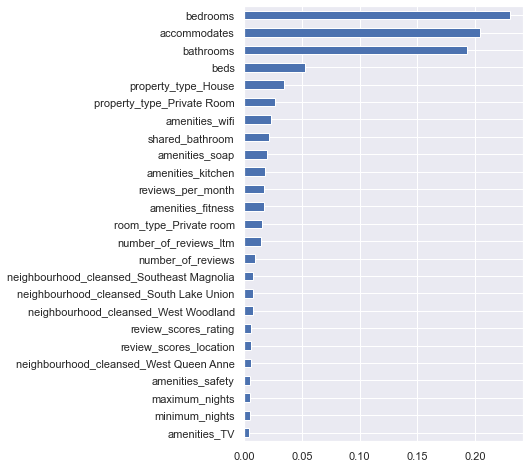

In [932]:
# Plot feature importances for the gradient boosting regressor
feat_imp = pd.Series(best_model_rf.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(1, 1, figsize=(5,8))
_ = feat_imp.nlargest(25).plot(kind='barh', ax=ax).invert_yaxis()

In [940]:
# Gradient Boosing Regressor
gb = GradientBoostingRegressor(random_state=42)

# Grid search parameters
# params_gb = {
#     'n_estimators': [50, 100],
#     'max_depth': [4, 5, 6],
#     'max_features': ['auto', 'sqrt', 0.2, 0.3],
#     'min_samples_leaf': [1, 16, 32]
# }

# Optimal parameters
params_gb = {
    'n_estimators': [100],
    'max_depth': [5],
    'max_features': [0.3],
    'min_samples_leaf': [32]
}

grid_gb = GridSearchCV(estimator=gb, param_grid=params_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_gb.fit(X_train, y_train.squeeze())

print('Best Hyperparameters:\n', grid_gb.best_params_, '\n')

best_model_gb = grid_gb.best_estimator_

#calculate scores for the model
y_train_pred = best_model_gb.predict(X_train)
y_test_pred  = best_model_gb.predict(X_test)

print('Gradient Boosting Regressor MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('Gradient Boosting Regressor R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Best Hyperparameters:
 {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 32, 'n_estimators': 100} 

Gradient Boosting Regressor MSE train: 7537.618, test: 4664.128
Gradient Boosting Regressor R^2 train: 0.517, test: 0.596


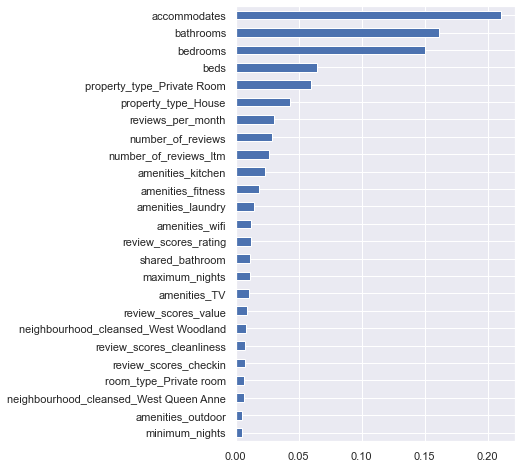

In [941]:
# Plot feature importances for the gradient boosting regressor
feat_imp = pd.Series(best_model_gb.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(1, 1, figsize=(5,8))
_ = feat_imp.nlargest(25).plot(kind='barh', ax=ax).invert_yaxis()